## 1、LightGBM介绍
LightGBM 是微软开发的 boosting 集成模型，和 XGBoost 一样是对 GBDT 的优化和高效实现，原理有一些相似之处，但它很多方面比 XGBoost 有着更为优秀的表现。官方给出的这个工具库模型的优势如下：

- 更快的训练效率
- 低内存使用
- 更高的准确率
- 支持并行化学习
- 可处理大规模数据
- 支持直接使用 category 特征

在实验中，LightGBM 比 XGBoost 快将近 10倍，内存占用率大约为 XGBoost 的 1/6，准确率也略有提升

## 2、LightGBM的背景
GBDT 在每一次迭代的时候，都需要遍历整个训练数据多次。

- 如果把整个训练数据一次性装进内存，会明显限制训练数据的大小。
- 如果不装进内存，反复地读写训练数据又会消耗非常大的时间。

面对工业级海量的数据，普通的 GBDT 算法无法满足需求。 LightGBM 提出的主要原因之一，就是为了解决上述大数据量级下的 GBDT 训练问题，以便工业实践中能支撑大数据量并保证效率。

## 3. XGBoost 优缺点
XGB优缺点归纳如下：

- 3.1、精确贪心算法

多轮迭代时，都需要遍历整个训练数据多次。如果把整个训练数据装进内存则会限制训练数据的大小；如果不装进内存，反复地读写训练数据又会消耗非常大的时间。
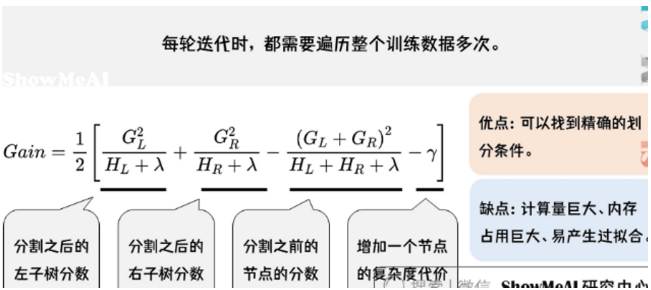

- **优点**：可以找到精确的划分条件。
- **缺点**：计算量巨大、内存占用巨大、易产生过拟合。


- 3.2、Level-wise生长方式

XGBoost 采用 Level-wise 的增长策略：基于层进行生长，直到达到停止条件。这种增长策略方便并行计算每一层的分裂节点，提高了训练速度，但同时也因为节点增益过小增加了很多不必要的分裂，增加了计算量
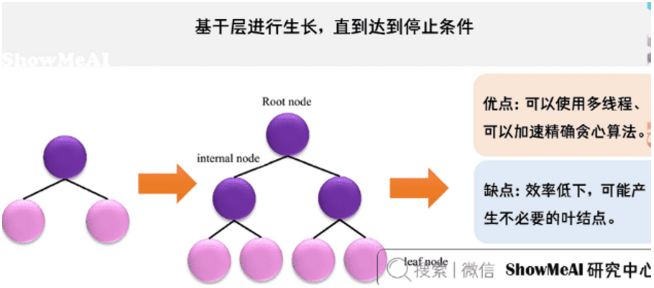

- **优点**：可以使用多线程、可以加速精确贪心算法。
- **缺点**：效率低下，可能产生不必要的叶结点。


- 3.3、对cache优化不友好

对cache优化不友好。在预排序后，特征对梯度的访问是一种随机访问，并且不同的特征访问的顺序不一样，无法对cache进行优化

## 4、LightGBM优势
LightGBM优势：

- 基于 Histogram 的决策树算法
- 带深度限制的 Leaf-wise 的叶子生长策略
- 直方图做差加速
- 直接支持类别特征（Categorical Feature）
- Cache命中率优化
- 基于直方图的稀疏特征优化
- 多线程优化

### 4.1 LightGBM:直方图算法
LightGBM 使用的是直方图算法,算法思想：

- 将连续的浮点特征离散成 k个离散值，并构造宽度为 k 的 histogram 。
- 遍历训练数据，统计每个离散值在直方图中的累计统计量。
- 在进行特征选择时，只需要根据直方图的离散值，遍历寻找最优的分割点。

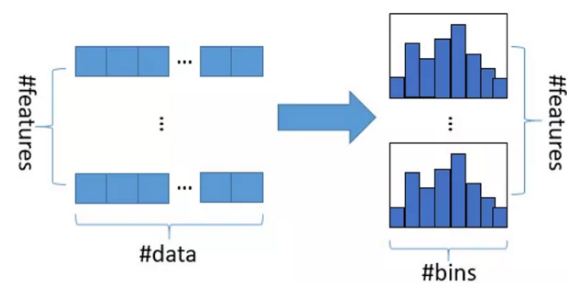

1、内存优化：直方图算法可以很大程度降低内存消耗，它不仅不需要额外存储预排序的结果，还可以只保存特征离散化后的值（一般用8位整型存储就足够了）
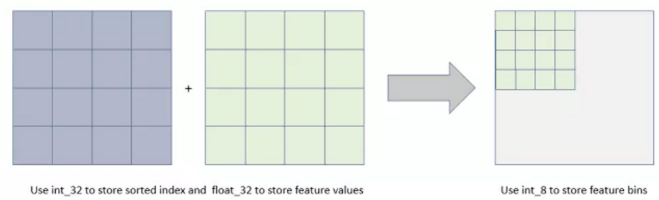
 
2、计算优化：应用直方图算法，计算代价也大幅降低，预排序算法每遍历一个特征值就需要计算一次分裂的增益，而直方图算法只需要计算 k次（可以认为是常数）

### 4.2、直方图算法的理解和注意点如下：
- 使用分桶 bin 替代原始数据相当于增加了正则化。
- 使用分桶 bin 意味着很多数据的细节特征丢失，相似的数据如果划分到相同的桶中，数据之间的差异就无法捕获了。
- 分桶 bin 数量决定了正则化的程度，bin 越少惩罚越严重，欠拟合风险越高。
- 因为预先设定了 bin 的范围，构建直方图时不需要对数据进行排序。
- 直方图保存「划分阈值」、「当前 bin 内样本数」、「当前 bin 内所有样本的一阶梯度和」。
- 阈值的选取是按照直方图从小到大遍历，使用了上面的一阶梯度和，目的是得到划分之后 损失函数 最大的特征及阈值。

## 5、决策树生长策略（LightGBM）原理
### 5.1、树生长策略调整
直方图算法之上，LightGBM 进行进一步的优化。它没有使用大多数 GBDT 工具使用的按层生长（Level-wise）的决策树生长策略，而使用了带有深度限制的按叶子生长（Leaf-wise）算法。

### 5.2、XGBoost ：Level-wise
XGBoost 采用的是Level-wise（按层生长）策略生长的，能够同时分裂同一层的叶子，从而进行多线程优化，不容易过拟合。

但不加区分的对待同一层的叶子，带来了很多没必要的开销。因为实际上很多叶子的分裂增益较低，没必要进行搜索和分裂。
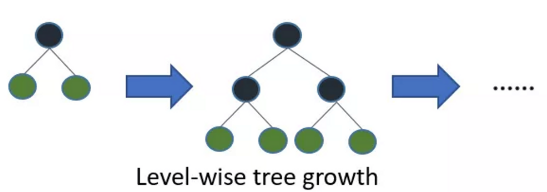

## 5.3、LightGBM ：Leaf-wise
LightGBM 采用 Leaf-wise（按叶子生长）生长策略，每次从当前所有叶子中找到分裂增益最大（一般也是数据量最大）的一个叶子，然后分裂，如此循环。
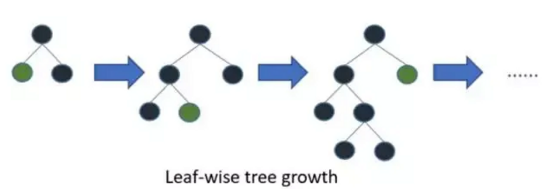
- Leaf-wise 可以降低更多的误差，得到更好的精度。
- Leaf-wise 的缺点是可能会长出比较深的决策树，产生过拟合。因此 LightGBM 在 Leaf-wise 之上增加了一个最大深度的限制，在保证高效率的同时防止过拟合

### 5.4、直方图差加速
LightGBM 另一个优化是 Histogram （直方图）做差加速。整个构建过程中可以观察到：一个叶子的直方图可以由它的父亲节点的直方图与它兄弟的直方图做差得到。
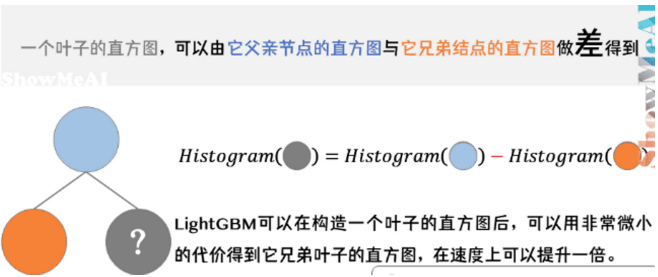

## 6. LightGBM的工程优化
### 6.1 直接支持类别特征
实际上大多数机器学习工具都无法直接支持类别特征，一般需要把类别特征，通过 one-hot 编码，转化到多维的特征，降低了空间和时间的效率

我们知道对于决策树来说并不推荐使用 one-hot 编码，尤其当类别特征中类别个数很多的情况下，会存在以下问题：

**问题1：可能无法在这个类别特征上进行切分**

- 使用 one-hot 编码的话，意味着在每一个决策节点上只能使用one vs rest
- 类别值很多时，每个类别上的数据可能会比较少，这时候切分会产生不平衡，这意味着切分增益也会很小

**问题2：影响决策树的学习**

- 就算可以在这个类别特征进行切分，也会把数据切分到很多零碎的小空间上
- 而决策树学习时利用的是统计信息，在这些数据量小的空间上，统计信息不准确，学习会变差

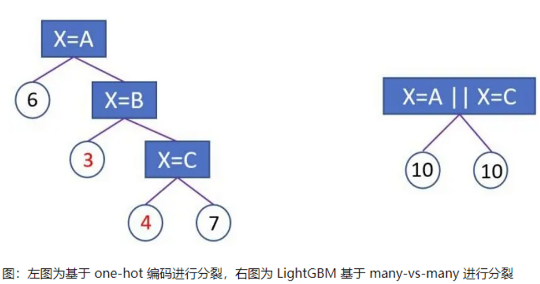

### 6.2、LightGBM 类别型特征处理方式
LightGBM 采用了 Many vs Many 的切分方式解决 one-hot 编码带来的问题，用 LightGBM 可以直接输入类别特征
**算法流程如图所示：**

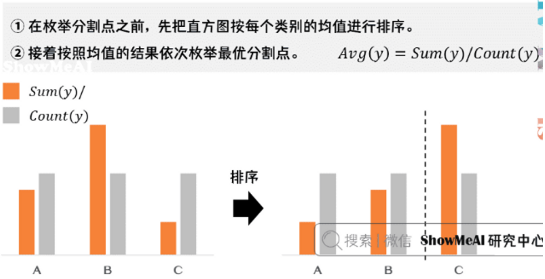

- 在枚举分割点之前，先把直方图按每个类别的均值进行排序。
- 接着按照均值的结果依次枚举最优分割点。

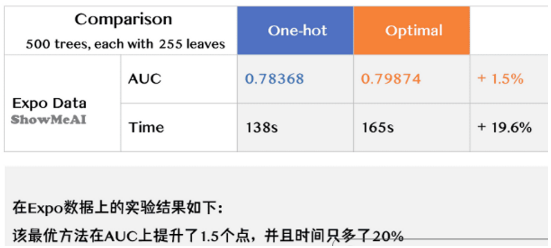

求解类别型特征的最优切分的具体流程如下：

① **离散特征建立直方图的过程**

统计该特征下每一种离散值出现的次数，并从高到低排序，并过滤掉出现次数较少的特征值。然后为每一个特征值，建立一个 bin 容器，对于在 bin 容器内出现次数较少的特征值直接过滤掉，不建立 bin 容器

② **计算分裂阈值的过程**

- 先看该特征下划分出的 bin 容器的个数，如果 bin 容器的数量小于 4，直接使用 one vs other 方式，逐个扫描每一个 bin 容器，找出最佳分裂点。
- 对于 bin 容器较多的情况，先进行过滤，只让子集合较大的 bin 容器参加划分阈值计算，对每一个符合条件的 bin 容器进行公式计算，得到一个值，根据该值对 bin 容器从小到大进行排序，然后分从左到右、从右到左进行搜索，得到最优分裂阈值。


③ **对于连续特征，划分阈值只有一个。对于离散值可能会有多个划分阈值，每一个划分阈值对应着一个 bin 容器编号**

## 7.并行支持与优化
LightGBM 原生支持并行学习，目前支持「特征并行」和「数据并行」的两种，LightGBM 针对这两种并行方法都做了优化。

- **特征并行**：在不同机器在不同的特征集合上分别寻找最优的分割点，然后在机器间同步最优的分割点。
- **数据并行**：让不同的机器先在本地构造直方图，然后进行全局的合并，最后在合并的直方图上面寻找最优分割点。

### 7.1、特征并行
LightGBM 在特征并行算法中，通过在本地保存全部数据避免对数据切分结果的通信。


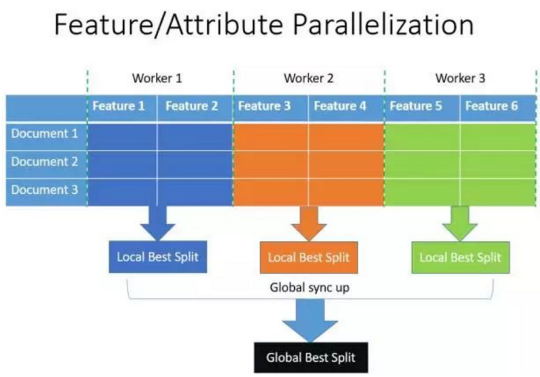
### 7.2、****数据并行****

- Lightgbm在数据并行中使用分散规约（Reduce scatter）把直方图合并的任务分摊到不同的机器，降低通信和计算成本，并利用直方图做差，进一步减少了一半的通信量。
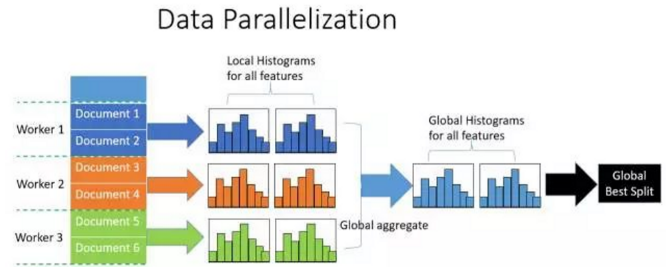

- 基于投票的数据并行则进一步优化数据并行中的通信代价，使通信代价变成常数级别。在数据量很大的时候，使用投票并行可以得到非常好的加速效果
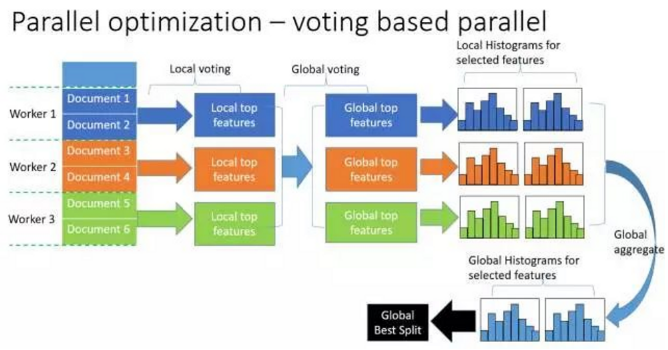

### 7.3、Cache命中率优化
LightGBM 所使用直方图算法对 Cache 天生友好：

- 首先，所有的特征都采用相同的方式获得梯度（区别于XGBoost的不同特征通过不同的索引获得梯度），只需要对梯度进行排序并可实现连续访问，大大提高了缓存命中率；
- 其次，因为不需要存储行索引到叶子索引的数组，降低了存储消耗，而且也不存在 Cache Miss的问题。

## 8. LightGBM的优缺点
### 8**.1 优点**

这部分主要总结下 LightGBM 相对于 XGBoost 的优点，从内存和速度两方面进行介绍。

### **（1）速度更快**

- LightGBM 采用了直方图算法将遍历样本转变为遍历直方图，极大的降低了时间复杂度；
- LightGBM 在训练过程中采用单边梯度算法过滤掉梯度小的样本，减少了大量的计算；
- LightGBM 采用了基于 Leaf-wise 算法的增长策略构建树，减少了很多不必要的计算量；
- LightGBM 采用优化后的特征并行、数据并行方法加速计算，当数据量非常大的时候还可以采用投票并行的策略；
- LightGBM 对缓存也进行了优化，增加了缓存命中率；

### **（2）内存更小**

- XGBoost使用预排序后需要记录特征值及其对应样本的统计值的索引，而 LightGBM 使用了直方图算法将特征值转变为 bin 值，且不需要记录特征到样本的索引，将空间复杂度从极大减小，极大的减少了内存消耗；
- LightGBM 采用了直方图算法将存储特征值转变为存储 bin 值，降低了内存消耗；
- LightGBM 在训练过程中采用互斥特征捆绑算法减少了特征数量，降低了内存消耗。

### 8**.2 缺点**

- 可能会长出比较深的决策树，产生过拟合。因此LightGBM在Leaf-wise之上增加了一个最大深度限制，在保证高效率的同时防止过拟合；
- Boosting族是迭代算法，每一次迭代都根据上一次迭代的预测结果对样本进行权重调整，所以随着迭代不断进行，误差会越来越小，模型的偏差（bias）会不断降低。由于LightGBM是基于偏差的算法，所以会对噪点较为敏感；
- 在寻找最优解时，依据的是最优切分变量，没有将最优解是全部特征的综合这一理念考虑进去；

## 代码实现：Iris分类-LightGBM
- sklearn
- pip3 install LightGBM


In [4]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

# 加载数据
iris = datasets.load_iris()

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3)

# 转换为Dataset数据格式
train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_test, label=y_test)

# 参数
params = {
    'learning_rate': 0.1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.2,
    'max_depth': 4,
    'objective': 'multiclass',  # 目标函数
    'num_class': 3,
}

# 模型训练
gbm = lgb.train(params, train_data, valid_sets=[validation_data])

# 模型预测
y_pred = gbm.predict(X_test)
y_pred = [list(x).index(max(x)) for x in y_pred]
print(y_pred)

# 模型评估
print(accuracy_score(y_test, y_pred))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 105, number of used features: 4
[LightGBM] [Info] Start training from score -1.070441
[LightGBM] [Info] Start training from score -1.188224
[LightGBM] [Info] Start training from score -1.043042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 0.960138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's multi_logloss: 0.834246
[LightGBM] [Warning] No f

In [5]:
# 模型评估
print(accuracy_score(y_test, y_pred))

0.9333333333333333
